# 마코위츠 최적화의 한계와 글로벌 최소분산 포트폴리오

마코위츠 최적화는 이론적으로 매우 흥미롭지만 현실적으로는 실패하는 경향이 있습니다. 그 이유는 바로 우리가 미래 시점의 기대 수익률과 기대 공분산에 대해 알 수가 없다는 점 때문입니다. 추정치는 결국 추정에 불과하면 거의 틀림없이 추정 오류가 발생합니다. 또한 마코위츠의 최적화는 매우 작은 추정 오차에도 굉장히 민감하게 반응하기 때문에 실무적으로 이를 적용하기에는 한계가 여실히 드러납니다.

이를 확인하기 위해 평소와 같이 데이터셋을 로드하여 시작해보겠습니다.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import port_opt_toolkit as potk

ind = potk.get_ind_returns()
er = potk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

간단한 2개 자산에 대해 포트폴리오를 살펴보고 기대 수익률이 주어진다면 최적의 가중치가 얼마인지 계산을 해보겠습니다.

In [2]:
l = ["Food", "Steel"]
import numpy as np
potk.msr(0.1, np.array(er[l]), cov.loc[l,l])

array([0.75355205, 0.24644795])

이러한 가중치를 부여한 두 자산의 기대 수익률을 살펴보겠습니다.

In [3]:
er[l]

Food     0.116799
Steel    0.115581
dtype: float64

이때 우리가 정말 좋은 추정 모델을 가지고 있고, 이것이 식품 및 철강에 대해 각각 11% 및 12%의 수익률을 추정했다고 가정해보겠습니다.

In [4]:
potk.msr(0.1, np.array([.11, .12]), cov.loc[l,l])

array([0.57933474, 0.42066526])

우리는 위의 결과를 통해 추정치의 작은 변화가 가중치에 큰 변화를 초래한다는 것을 알 수 있습니다. 그렇다면 만약 추정 오차가 2%가 되어 각각의 기대 수익률이 11.6%, 11.5% 대신 10%, 13%로 추정되었다면 결과는 어떻게 달라질까요?

In [5]:
potk.msr(0.1, np.array([.10, .13]), cov.loc[l,l])

array([0., 1.])

그리고 만약 우리가 동일한 추정 오류를 범했지만 반대 방향으로 작용했다면 어떻게 되었을까요?

In [7]:
potk.msr(0.1, np.array([.13, .10]), cov.loc[l,l])

array([1., 0.])

# 기대 수익률 추정을 피하는 법

효율적 경계선을 한 번 더 살펴보고 다시 한 번 이것을 그려보겠습니다.

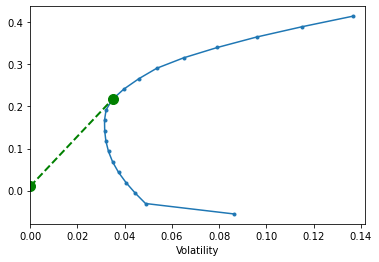

In [11]:
potk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.01)

기대 수익률 추정을 피하는 한 가지 방법은 전체 프로세스를 건너뛰고 모든 주식을 동일한 가중치로 보유하는 방법입니다. 우리는 이를 **동일가중 포트폴리오(Equal-Weighted Portfolio)**라고 부릅니다. 다음과 같이 `plot_ef` 기능을 향상시켜 동일가중 포트폴리오를 플롯에 추가할 수 있습니다.

```python
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # add EW
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
```

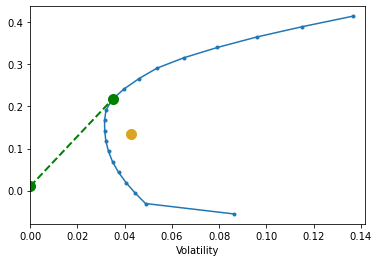

In [12]:
potk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.01, show_ew=True)

효율적 경계선 상에서 매우 흥미로운 또 다른 지점이 있습니다. 이 지점은 효율적 경계선 내의 가능한 모든 포트폴리오 중 가장 낮은 변동성을 갖는 포트폴리오입니다. 우리는 이를 최소 변동성 또는 **글로벌 최소변동성 포트폴리오(GMV Portfolio, Global Minimum Volatility Portfolio)**라고 합니다.

그런데 어떻게 이 글로벌 최소변동성 포트폴리오의 가중치를 구할 수 있을까요?

흥미로운 점은 모든 수익률이 동일하다고 가정하면 최적화 알고리즘이 수익률을 높여서 샤프 비율을 개선할 수 없기 때문에 변동성을 낮추어 최적 포트폴리오를 찾습니다. 즉, 수익률 추정을 건너뛰고 모든 수익률이 동일하다고 가정하면 최적화 알고리즘은 GMV 포트폴리오의 가중치를 반환합니다.

```python
def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)
```

and we can add that to the plot as follows:

```python
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # add EW
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)
```

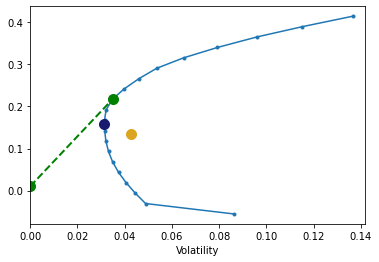

In [14]:
potk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.01, show_ew=True, show_gmv=True)